In [126]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymutspec.annotation import calculate_mutspec, CodonAnnotation, mutations_summary
from pymutspec.constants import possible_sbs192, possible_codons 
from scipy.spatial.distance import pdist, cdist, squareform, cosine

sns.set_style()

In [2]:
coda = CodonAnnotation(2)

## Load prepared mutations and reference

In [3]:
mutations = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [4]:
Ref = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/ref_annot.csv")
print(Ref.shape)
Ref.head()

(16569, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN


### Describe observed mutations

In [5]:
mutations[mutations.Label == 0].tissue.value_counts().rename('#non-syn').to_frame()\
    .join(mutations[mutations.Label > 0].tissue.value_counts().rename('#syn'))\
        .sort_values('#syn', ascending=False)

,#non-syn,#syn
Liver,1090,136
Kidney,708,91
Pancreas,736,88
Breast,586,77
Prostate,639,66
Esophagus,348,51
Lymphoid,266,44
Ovary,342,42
Skin,176,35
CNS,224,32


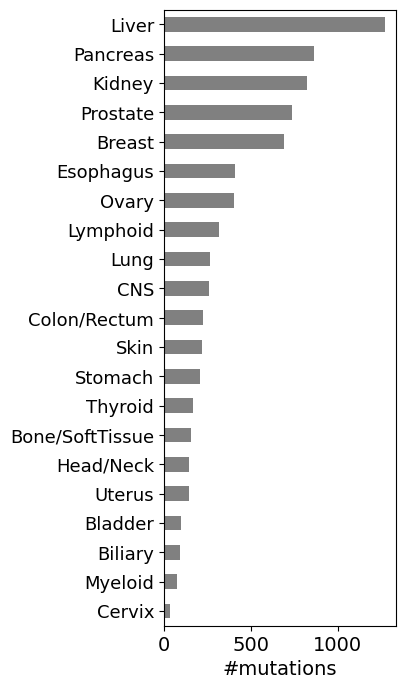

In [6]:
plt.figure(figsize=(3, 8))
mutations.tissue.value_counts(ascending=True).plot.barh(color="gray")
plt.xlabel("#mutations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.show()

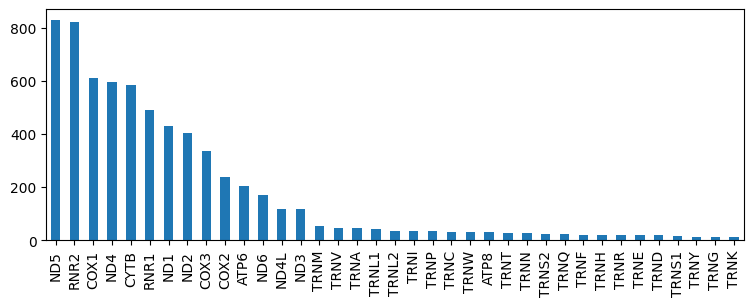

In [7]:
plt.figure(figsize=(9, 3))
mutations.GeneName.value_counts().plot.bar();

In [8]:
mutations.Strand.value_counts()

 1    6209
-1    1359
 0      43
Name: Strand, dtype: int64

In [9]:
mutations.Label.value_counts()

 0    6488
 2     462
 1     373
-1     278
-3      10
Name: Label, dtype: int64

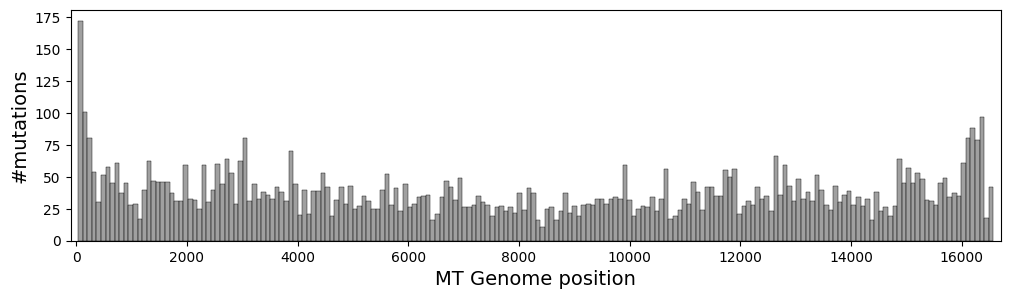

In [10]:
plt.figure(figsize=(12, 3))
# plt.title("Distribution of mutaions on genome")
plt.xlabel("MT Genome position", fontsize=14)
plt.ylabel("#mutations", fontsize=14)
sns.histplot(mutations.Pos, bins=200, color="gray")
plt.xlim(-100, 16700)
plt.show()

In [11]:
mutations_summary(mutations)

,non-syn,syn,syn4f,Stop gain,Stop to stop
_ProbaFull,6488,835,462,278,10


In [12]:
mutations_summary(mutations, gene_col="GeneName")

,non-syn,syn,syn4f,Stop gain,Stop to stop
GeneName,,,,,
ATP6,150,51,31,5,0
ATP8,11,13,2,5,0
COX1,428,124,72,59,0
COX2,184,45,28,9,1
COX3,261,47,22,30,0
CYTB,450,83,49,50,3
ND1,337,74,44,17,3
ND2,285,90,56,27,3
ND3,83,29,7,4,0


## Tissue/cancer type specific spectra

In [13]:
obs_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Label >= 0)
]

In [14]:
ref_cur = Ref[(Ref.Type != "D-loop")].assign(AltNuc="ACGT")
ref_cur["AltNuc"] = ref_cur.AltNuc.apply(list)
ref_cur["AltCodon"] = ref_cur.apply(
    lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else [], axis=1)

exp_all = ref_cur.explode("AltNuc")
exp_all = exp_all[exp_all.Nuc != exp_all.AltNuc]
exp_all["Sbs12"] = exp_all.Nuc + ">" + exp_all.AltNuc
exp_all["Sbs192"] = exp_all.Context.str.get(0) + "[" + exp_all["Sbs12"] + "]" + exp_all.Context.str.get(-1)

exp_syn = ref_cur.explode("AltCodon").dropna(subset="AltCodon")
exp_syn["Sbs12"] = exp_syn.Nuc + ">" + exp_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_syn["Sbs192"] = exp_syn.Context.str.get(0) + "[" + exp_syn["Sbs12"] + "]" + exp_syn.Context.str.get(-1)

exp_all_freqs = exp_all.Sbs192.value_counts().to_dict()
exp_syn_freqs = exp_syn.Sbs192.value_counts().to_dict()

In [15]:
exp_syn

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltNuc,AltCodon,Sbs12,Sbs192
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0,"[A, C, G, T]",ATG,A>G,T[A>G]C
3311,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,"[A, C, G, T]",CCT,C>T,C[C>T]A
3311,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,"[A, C, G, T]",CCA,C>A,C[C>A]A
3311,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,"[A, C, G, T]",CCG,C>G,C[C>G]A
3314,3315,G,TGG,1,CDS,ND1,9,3,ATG,11757.0,"[A, C, G, T]",ATA,G>A,T[G>A]G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15879,15880,A,AAT,1,CDS,CYTB,1134,3,AAA,20164.0,"[A, C, G, T]",AAG,A>G,A[A>G]T
15882,15883,G,GGG,1,CDS,CYTB,1137,3,TGG,20170.0,"[A, C, G, T]",TGA,G>A,G[G>A]G
15885,15886,C,CCT,1,CDS,CYTB,1140,3,GCC,20176.0,"[A, C, G, T]",GCG,C>G,C[C>G]T
15885,15886,C,CCT,1,CDS,CYTB,1140,3,GCC,20176.0,"[A, C, G, T]",GCA,C>A,C[C>A]T


In [127]:
obs_all.tissue

0         Bladder
1        Pancreas
2         Bladder
3         Bladder
4       Esophagus
          ...    
7606       Uterus
7607       Uterus
7608       Uterus
7609       Uterus
7610       Uterus
Name: tissue, Length: 6340, dtype: object

In [16]:
tissue_mut_cnt = obs_all.tissue.value_counts()
tissue_mut_cnt = tissue_mut_cnt[tissue_mut_cnt > 100]
tissue_mut_cnt

Liver              1055
Pancreas            728
Kidney              651
Prostate            625
Breast              564
Ovary               351
Esophagus           338
Lymphoid            280
Lung                229
CNS                 220
Skin                186
Colon/Rectum        171
Stomach             168
Thyroid             140
Uterus              132
Bone/SoftTissue     125
Head/Neck           118
Name: tissue, dtype: int64

In [214]:
obs_all

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,Uterus,4.0,97.4400,2311,T,GTA,1,rRNA,RNR2,-1,-1,NaN,9749.0,NaN,0,G[T>C]A
7607,Uterus,4.0,20.5300,3417,C,CCA,1,CDS,ND1,111,3,CCC,11961.0,CCT,2,C[C>T]A
7608,Uterus,4.0,67.3200,5267,T,TTA,1,CDS,ND2,798,3,ATT,15661.0,ATC,1,T[T>C]A
7609,Uterus,4.0,4.7800,14775,T,CTA,1,CDS,CYTB,29,2,CTA,17954.0,CCA,0,C[T>C]A


In [477]:
data = []

# first of all - full cancer spectrum
cur_obs_all = obs_all
cur_obs_syn = obs_all[(obs_all.Label > 0)]
ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue='All tissues', muttype='all')
ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue='All tissues', muttype='syn')
data.append(ms_all)
data.append(ms_syn)

for tis in obs_all.tissue.unique():
    cur_obs_all = obs_all[obs_all.tissue == tis]
    cur_obs_syn = obs_all[(obs_all.tissue == tis) & (obs_all.Label > 0)]

    if len(cur_obs_all) < 130 or tis == 'Thyroid':
        continue
    
    # exp_all_freqs
    # exp_syn_freqs

    ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue=tis, muttype='all')
    data.append(ms_all)

    ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue=tis, muttype='syn')
    data.append(ms_syn)

In [478]:
spectra_tissue_specific = pd.concat(data, ignore_index=True)
spectra_tissue_specific.to_csv('../data/human_cancer_spectra_tissue_specific.csv', index=False)
spectra_tissue_specific

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec,tissue,muttype
0,A[A>C]C,15,463.0,0.032397,0.000837,All tissues,all
1,A[A>C]G,1,196.0,0.005102,0.000132,All tissues,all
2,A[A>C]T,1,355.0,0.002817,0.000073,All tissues,all
3,A[A>G]A,9,494.0,0.018219,0.000471,All tissues,all
4,A[A>G]C,79,463.0,0.170626,0.004409,All tissues,all
...,...,...,...,...,...,...,...
5755,A[C>G]G,0,NaN,0.000000,0.000000,Skin,syn
5756,C[A>G]A,0,101.0,0.000000,0.000000,Skin,syn
5757,G[G>T]T,0,6.0,0.000000,0.000000,Skin,syn
5758,A[G>C]A,0,NaN,0.000000,0.000000,Skin,syn


In [479]:
spectra_tissue_specific_wide = spectra_tissue_specific.pivot(['tissue', 'muttype'], 'Mut', 'MutSpec')
spectra_tissue_specific_wide.head()

Mut                  A[A>C]A   A[A>C]C   A[A>C]G   A[A>C]T   A[A>G]A  \
tissue      muttype                                                    
All tissues all          0.0  0.000837  0.000132  0.000073  0.000471   
            syn          0.0  0.000000  0.000000  0.000000  0.000339   
Breast      all          0.0  0.002032  0.000000  0.000000  0.000000   
            syn          0.0  0.000000  0.000000  0.000000  0.000000   
CNS         all          0.0  0.003312  0.000000  0.000000  0.000000   

Mut                   A[A>G]C   A[A>G]G   A[A>G]T   A[A>T]A   A[A>T]C  ...  \
tissue      muttype                                                    ...   
All tissues all      0.004409  0.001319  0.002184  0.000628  0.000223  ...   
            syn      0.001680  0.001620  0.003024  0.000000  0.000000  ...   
Breast      all      0.008128  0.003200  0.003534  0.000635  0.000000  ...   
            syn      0.004639  0.011928  0.000000  0.000000  0.000000  ...   
CNS         all      0.006625  0.000000  0.002160  0.003105  0.000000  ...   

Mut                  T[T>A]G  T[T>A]T   T[T>C]A   T[T>C]C   T[T>C]G   T[T>C]T  \
tissue      muttype                                                             
All tissues all          0.0      0.0  0.006897  0.009790  0.009939  0.008279   
            syn          0.0      0.0  0.008820  0.007762  0.009996  0.006193   
Breast      all          0.0      0.0  0.015126  0.011774  0.012062  0.010861   
            syn          0.0      0.0  0.013916  0.003896  0.012988  0.000000   
CNS         all          0.0      0.0  0.002466  0.010469  0.000000  0.013279   

Mut                  T[T>G]A  T[T>G]C   T[T>G]G  T[T>G]T  
tissue      muttype                                       
All tissues all          0.0      0.0  0.000745      0.0  
            syn          0.0      0.0  0.007217      0.0  
Breast      all          0.0      0.0  0.000000      0.0  
            syn          0.0      0.0  0.000000      0.0  
CNS         all          0.0      0.0  0.007373      0.0  

[5 rows x 192 columns]

## Compare all ans syn by cossim

In [480]:
tissues_lst = list(spectra_tissue_specific.tissue.unique())
print("Used tissues:")
print(tissues_lst)

data_compare_all_syn = []
for t in tissues_lst:
    sp = spectra_tissue_specific_wide.loc[t]
    if len(sp) == 1:
        continue
    cossim_all_vs_syn = 1 - pdist(sp, 'cosine')[0]

    # cossim on reduced spectra
    cossim_all_vs_syn_red = 1 - pdist(sp.loc[:, ~(sp == 0).any(axis=0)], 'cosine')[0]

    # num of observed mutations
    if t == 'All tissues':
        nobs_all = obs_all[(obs_all.Label >= 0)].shape[0]
        nobs_syn = obs_all[(obs_all.Label >= 1)].shape[0]
    else:
        nobs_all = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 0)].shape[0]
        nobs_syn = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 1)].shape[0]

    # 
    nmuttypes = (sp != 0).sum(axis=1)

    data_compare_all_syn.append([
        t, cossim_all_vs_syn, cossim_all_vs_syn_red, 
        nobs_all, nmuttypes.loc['all'], nobs_syn, nmuttypes.loc['syn']
    ])

Used tissues:
['All tissues', 'Pancreas', 'Esophagus', 'Liver', 'Breast', 'Colon/Rectum', 'Prostate', 'Kidney', 'Lung', 'Ovary', 'Lymphoid', 'Uterus', 'CNS', 'Stomach', 'Skin']


In [481]:
_cols = ['tissue', 'cossim', 'cossim_red', 'nobs_all', 'nmuttypes_all', 'nobs_syn', 'nmuttypes_syn']
df_compare_all_syn = pd.DataFrame(
    data_compare_all_syn, columns=_cols).sort_values('cossim', ascending=False)
df_compare_all_syn.to_csv('../data/human_cancer_spectra_all_vs_syn.csv', index=False)
df_compare_all_syn

,tissue,cossim,cossim_red,nobs_all,nmuttypes_all,nobs_syn,nmuttypes_syn
0,All tissues,0.934303,0.936709,6340,160,835,93
3,Liver,0.867749,0.870210,1055,95,136,58
7,Kidney,0.802461,0.830637,651,97,91,50
1,Pancreas,0.715208,0.811345,728,93,88,49
10,Lymphoid,0.700047,0.789202,280,72,44,32
12,CNS,0.697525,0.922091,220,64,32,25
6,Prostate,0.689012,0.797529,625,70,66,37
14,Skin,0.666867,0.840921,186,58,35,25
11,Uterus,0.608831,0.905531,132,46,26,18
4,Breast,0.587079,0.773904,564,88,77,42


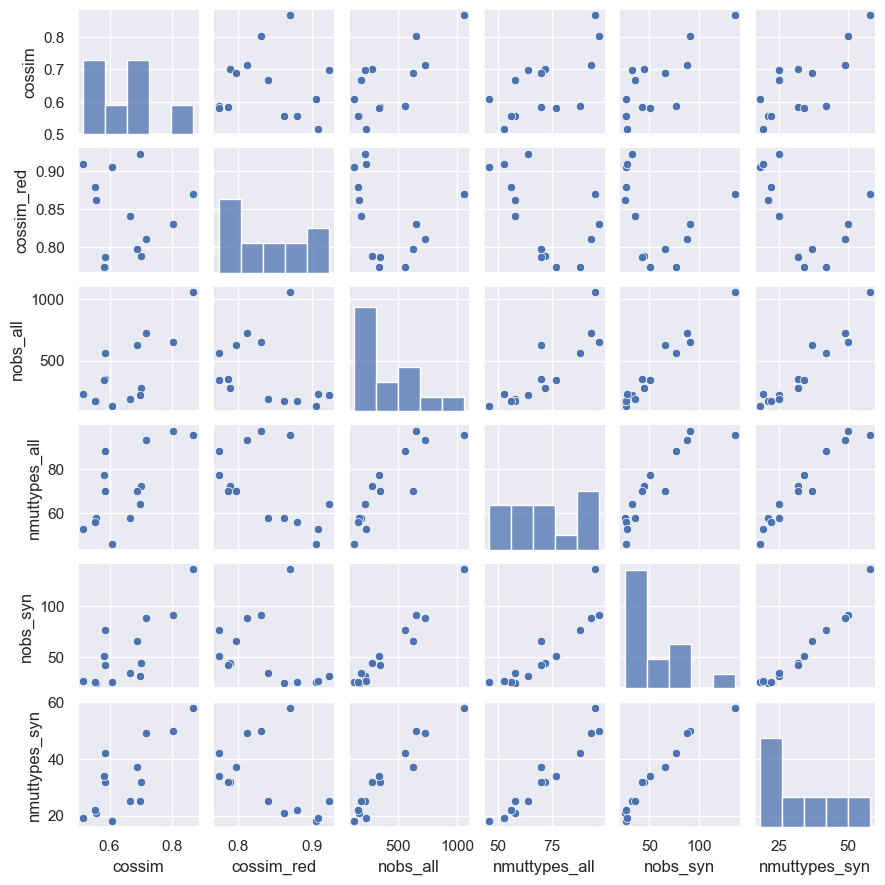

In [482]:
sns.pairplot(df_compare_all_syn.iloc[1:], size=1.5)

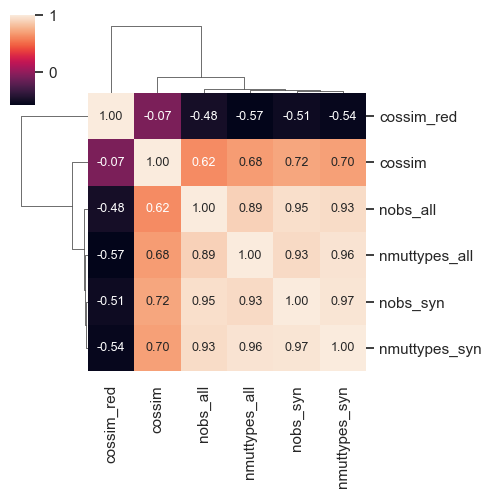

In [483]:
sns.clustermap(df_compare_all_syn.iloc[1:].corr('spearman'), annot=True, fmt='.2f', figsize=(5,5), annot_kws={'fontsize': 9})

# Compare all vs all

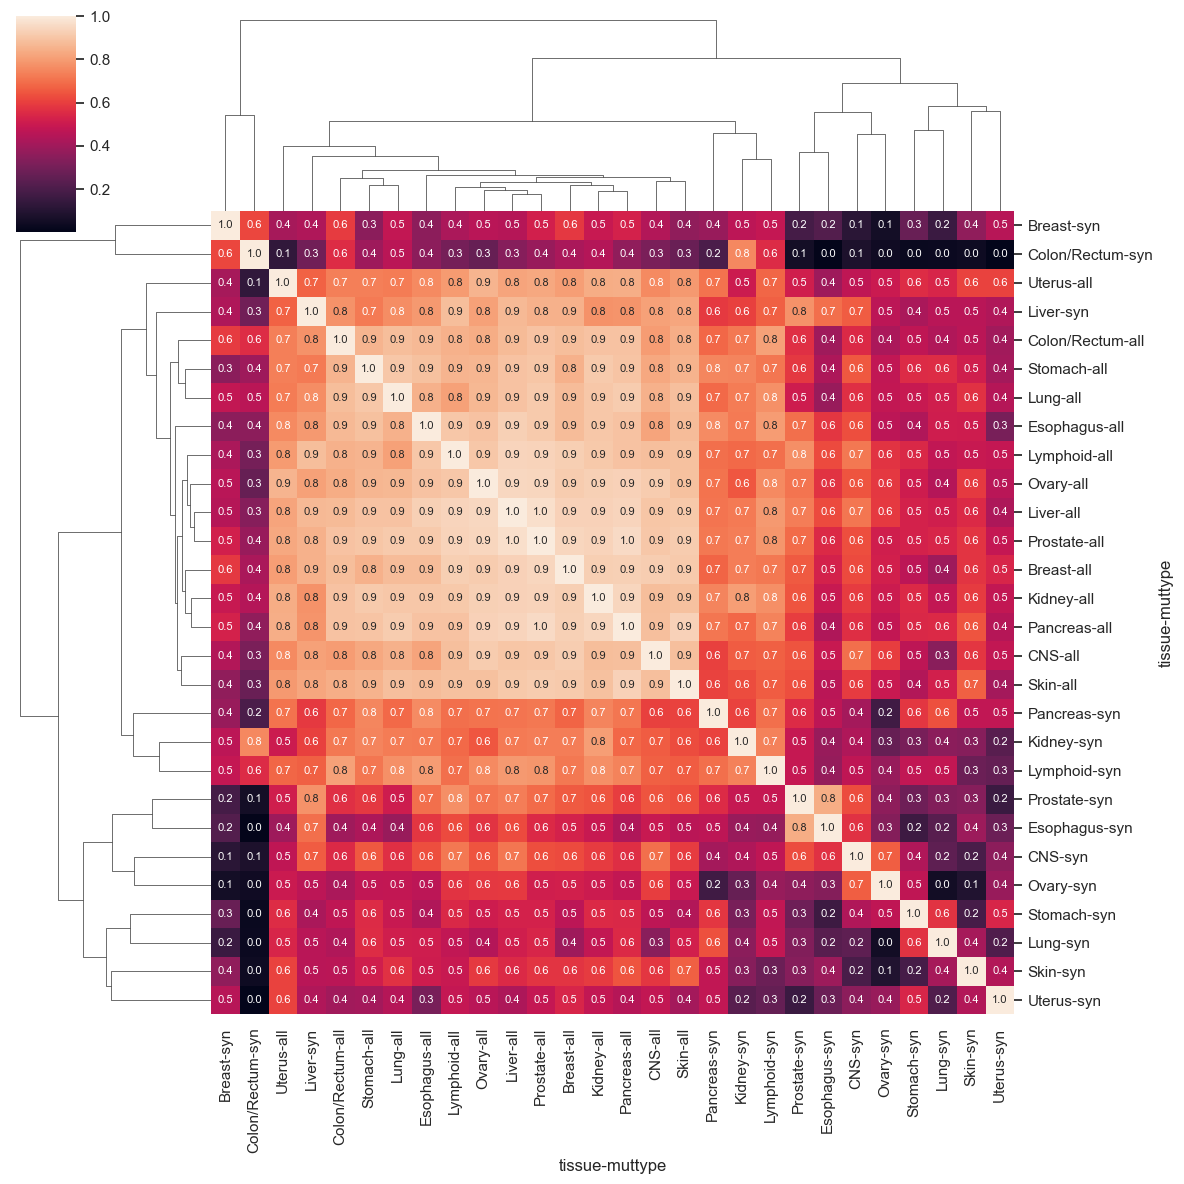

In [485]:
_x = spectra_tissue_specific_wide.loc[df_compare_all_syn.tissue.values[1:]]
d = pd.DataFrame(1 - squareform(pdist(_x, 'cosine')), columns=_x.index, index=_x.index)
sns.clustermap(d, figsize=(12, 12), annot=True, fmt='.1f', annot_kws={'fontsize': 8})

<AxesSubplot:xlabel='muttype-tissue', ylabel='muttype-tissue'>

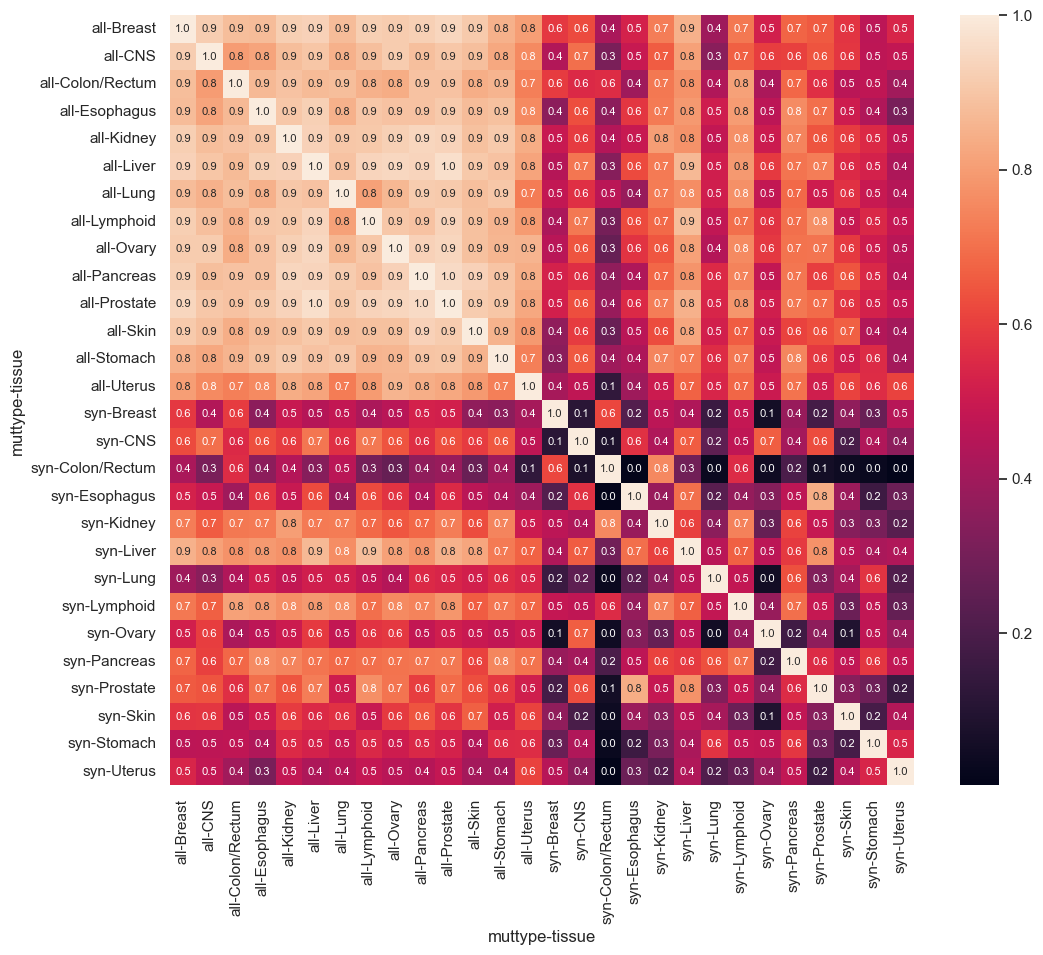

In [487]:
plt.figure(figsize=(12, 10))

_x = spectra_tissue_specific_wide.loc[df_compare_all_syn.tissue.values[1:]]
_x.index = _x.index.reorder_levels([1,0])
_x = _x.sort_index()


d = pd.DataFrame(1 - squareform(pdist(_x, 'cosine')), columns=_x.index, index=_x.index)

sns.heatmap(d, annot=True, fmt='.1f', annot_kws={'fontsize': 8})

## Try to vizualize `all vs syn` spectra on one plot

### PCA - bad

In [488]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is stored in the variable spectra_tissue_specific_wide

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra_tissue_specific_wide.iloc[2:])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Get the variance share of each principal component
variance_ratio = pca.explained_variance_ratio_
variance_share_pc1 = round(variance_ratio[0]*100, 2)
variance_share_pc2 = round(variance_ratio[1]*100, 2)

pca_df['tissue'] = spectra_tissue_specific_wide.index.get_level_values(0)[2:]
pca_df['muttype'] = spectra_tissue_specific_wide.index.get_level_values(1)[2:]
pca_df.head()

,PC1,PC2,tissue,muttype
0,6.433204,1.443970,Breast,all
1,-2.112430,0.938608,Breast,syn
2,4.751218,-7.476835,CNS,all
3,-2.710734,-2.242235,CNS,syn
4,0.365454,-4.842895,Colon/Rectum,all


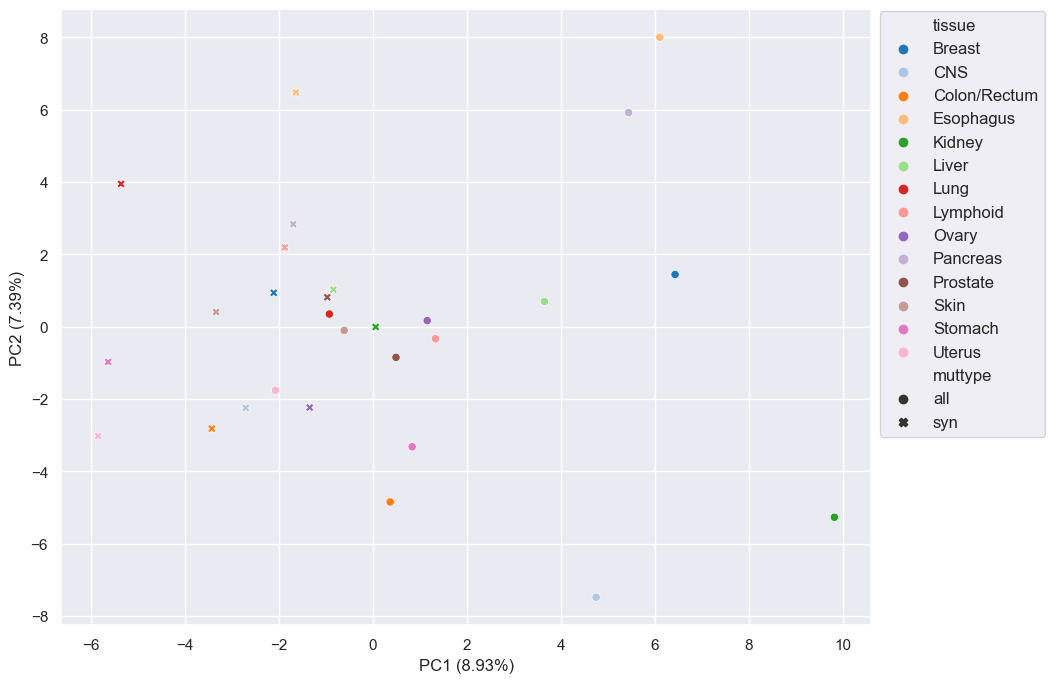

In [489]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='tissue', style='muttype', palette='tab20')
# ax.set_xlim(-10.5, 8)
ax.set_xlabel(f'PC1 ({variance_share_pc1}%)')
ax.set_ylabel(f'PC2 ({variance_share_pc2}%)')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

plt.show()

### UMAP - nice

In [490]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra_tissue_specific_wide.iloc[2:])

# Create UMAP instance and fit the data
umap_instance = umap.UMAP(n_neighbors=3, n_components=2, metric='cosine',  random_state=777)#, learning_rate=2., n_epochs=100000)
umap_result = umap_instance.fit_transform(scaled_data)

# Create a new dataframe with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['tissue'] = spectra_tissue_specific_wide.index.get_level_values(0)[2:]
umap_df['muttype'] = spectra_tissue_specific_wide.index.get_level_values(1)[2:]

# add cool labels
t2tlabel = dict(df_compare_all_syn.apply(lambda x: (x.tissue, f"{x.tissue} ({x.cossim:.2f}, {x.cossim_red:.2f})"), axis=1).values)
umap_df['tissue_label'] = umap_df['tissue'].map(t2tlabel)

umap_df.head()

,UMAP1,UMAP2,tissue,muttype,tissue_label
0,-2.569812,-0.069758,Breast,all,"Breast (0.59, 0.77)"
1,-2.259503,-0.255096,Breast,syn,"Breast (0.59, 0.77)"
2,-2.376199,-2.151682,CNS,all,"CNS (0.70, 0.92)"
3,-3.251924,-1.597431,CNS,syn,"CNS (0.70, 0.92)"
4,-1.384376,-1.198102,Colon/Rectum,all,"Colon/Rectum (0.56, 0.86)"


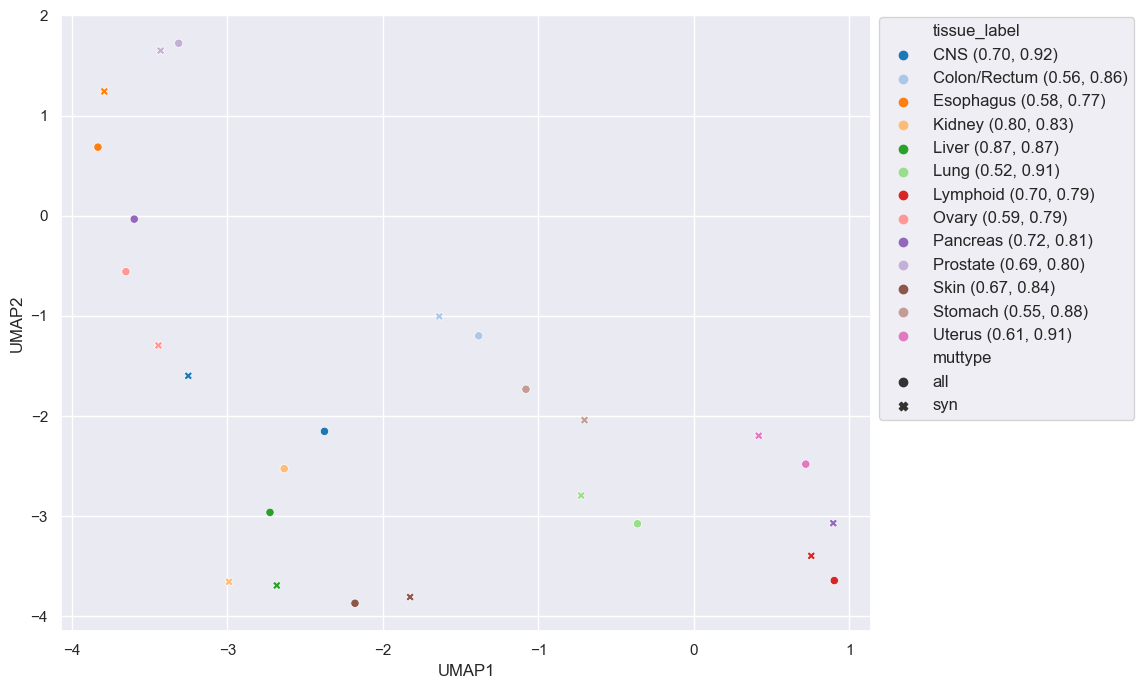

In [491]:
# Visualize the UMAP results
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=umap_df.iloc[2:], x='UMAP1', y='UMAP2', hue='tissue_label', style='muttype', palette='tab20', )

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.savefig('../pictures/human_cancer_spectra_tissues_umap.pdf')
plt.show()

## For asymmetry

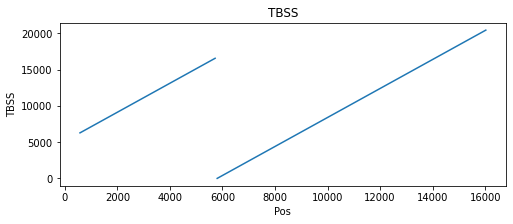

In [12]:
plt.figure(figsize=(8, 3))
plt.plot(Ref.Pos, Ref.TBSS)
plt.title("TBSS")
plt.ylabel("TBSS")
plt.xlabel("Pos")
plt.show()

In [24]:
major_arc_min_pos = 5800
major_arc_max_pos = 16000

region_size = 5000
print(f"Low TSSS region: {major_arc_min_pos}-{major_arc_min_pos+region_size}\nHigh TSSS region: {major_arc_max_pos-region_size}-{major_arc_max_pos}\n")
print("Please check that they are not intersect!!")

Low TSSS region: 5800-10800
High TSSS region: 11000-16000

Please check that they are not intersect!!


**Prepare OBS**

In [14]:
obs_low_tsss_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Pos > major_arc_min_pos) &
    (mutations.Pos < major_arc_min_pos+region_size) & 
    (mutations.Strand == 1)
]
obs_high_tsss_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Pos > major_arc_max_pos-region_size) &
    (mutations.Pos < major_arc_max_pos) &
    (mutations.Strand == 1)
]

obs_low_tsss_syn = obs_low_tsss_all[obs_low_tsss_all.Label >= 1]
obs_high_tsss_syn = obs_high_tsss_all[obs_high_tsss_all.Label >= 1]

print(obs_low_tsss_all.shape, obs_high_tsss_all.shape)
print(obs_low_tsss_syn.shape, obs_high_tsss_syn.shape)

(1724, 16) (2048, 16)
(338, 16) (321, 16)


In [15]:
print(
    obs_low_tsss_all.TBSS.mean().round(),
    obs_low_tsss_syn.TBSS.mean().round(),
    obs_high_tsss_all.TBSS.mean().round(),
    obs_high_tsss_syn.TBSS.mean().round(),
)

5073.0 4956.0 15170.0 14981.0


**Prepare EXP**

In [16]:
cur_ref = Ref[(Ref.Type != "D-loop")].assign(AltNuc="ACGT")
cur_ref["AltNuc"] = cur_ref.AltNuc.apply(list)
cur_ref["AltCodon"] = cur_ref.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon > -1 else [], axis=1)

ref_low_tsss = cur_ref[
    (cur_ref.Pos > major_arc_min_pos) &
    (cur_ref.Pos < major_arc_min_pos+region_size) & 
    (cur_ref.Strand == 1)
]
ref_high_tsss = cur_ref[
    (cur_ref.Pos > major_arc_max_pos-region_size) &
    (cur_ref.Pos < major_arc_max_pos) &
    (cur_ref.Strand == 1)
]

In [17]:
exp_low_tsss_all = ref_low_tsss.explode("AltNuc")
exp_low_tsss_all = exp_low_tsss_all[exp_low_tsss_all.Nuc != exp_low_tsss_all.AltNuc]
exp_low_tsss_all["Sbs12"] = exp_low_tsss_all.Nuc + ">" + exp_low_tsss_all.AltNuc
exp_low_tsss_all["Sbs192"] = exp_low_tsss_all.Context.str.get(0) + "[" + exp_low_tsss_all["Sbs12"] + "]" + exp_low_tsss_all.Context.str.get(-1)

exp_low_tsss_syn = ref_low_tsss.explode("AltCodon").dropna(subset="AltCodon")
exp_low_tsss_syn["Sbs12"] = exp_low_tsss_syn.Nuc + ">" + exp_low_tsss_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_low_tsss_syn["Sbs192"] = exp_low_tsss_syn.Context.str.get(0) + "[" + exp_low_tsss_syn["Sbs12"] + "]" + exp_low_tsss_syn.Context.str.get(-1)


exp_high_tsss_all = ref_high_tsss.explode("AltNuc")
exp_high_tsss_all = exp_high_tsss_all[exp_high_tsss_all.Nuc != exp_high_tsss_all.AltNuc]
exp_high_tsss_all["Sbs12"] = exp_high_tsss_all.Nuc + ">" + exp_high_tsss_all.AltNuc
exp_high_tsss_all["Sbs192"] = exp_high_tsss_all.Context.str.get(0) + "[" + exp_high_tsss_all["Sbs12"] + "]" + exp_high_tsss_all.Context.str.get(-1)

exp_high_tsss_syn = ref_high_tsss.explode("AltCodon").dropna(subset="AltCodon")
exp_high_tsss_syn["Sbs12"] = exp_high_tsss_syn.Nuc + ">" + exp_high_tsss_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_high_tsss_syn["Sbs192"] = exp_high_tsss_syn.Context.str.get(0) + "[" + exp_high_tsss_syn["Sbs12"] + "]" + exp_high_tsss_syn.Context.str.get(-1)


exp_low_tsss_all_freqs = exp_low_tsss_all.Sbs192.value_counts().to_dict()
exp_low_tsss_syn_freqs = exp_low_tsss_syn.Sbs192.value_counts().to_dict()
exp_high_tsss_all_freqs = exp_high_tsss_all.Sbs192.value_counts().to_dict()
exp_high_tsss_syn_freqs = exp_high_tsss_syn.Sbs192.value_counts().to_dict()

print(exp_low_tsss_all.shape)
print(exp_low_tsss_syn.shape)
print(exp_high_tsss_all.shape)
print(exp_high_tsss_syn.shape)

(14394, 14)
(3271, 14)
(13065, 14)
(2976, 14)


In [18]:
print(
    exp_low_tsss_all.TBSS.mean().round(),
    exp_low_tsss_syn.TBSS.mean().round(),
    exp_high_tsss_all.TBSS.mean().round(),
    exp_high_tsss_syn.TBSS.mean().round(),
)

5134.0 5067.0 15091.0 15088.0


In [19]:
ms_low_tsss_all = calculate_mutspec(obs_low_tsss_all, exp_low_tsss_all_freqs, use_context=True)
ms_low_tsss_syn = calculate_mutspec(obs_low_tsss_syn, exp_low_tsss_syn_freqs, use_context=True)
ms_high_tsss_all = calculate_mutspec(obs_high_tsss_all, exp_high_tsss_all_freqs, use_context=True)
ms_high_tsss_syn = calculate_mutspec(obs_high_tsss_syn, exp_high_tsss_syn_freqs, use_context=True)

In [20]:
ms_low_tsss_all.to_csv("../data/cancer_asymmetry/ms_low_tsss_all.csv", index=False)
ms_low_tsss_syn.to_csv("../data/cancer_asymmetry/ms_low_tsss_syn.csv", index=False)
ms_high_tsss_all.to_csv("../data/cancer_asymmetry/ms_high_tsss_all.csv", index=False)
ms_high_tsss_syn.to_csv("../data/cancer_asymmetry/ms_high_tsss_syn.csv", index=False)

In [21]:
print(ms_low_tsss_all.MutSpec.isna().sum(),
    ms_low_tsss_syn.MutSpec.isna().sum(),
    ms_high_tsss_all.MutSpec.isna().sum(),
    ms_high_tsss_syn.MutSpec.isna().sum()
)

0 0 0 0


In [22]:
print((ms_low_tsss_all.MutSpec == 0).sum(),
    (ms_low_tsss_syn.MutSpec == 0).sum(),
    (ms_high_tsss_all.MutSpec == 0).sum(),
    (ms_high_tsss_syn.MutSpec == 0).sum()
)

75 121 70 122
